In [1]:
import pandas as pd
import numpy as np
import seaborn as sb

import matplotlib.pyplot as plt

from scipy.stats import norm

# Payoffy

In [2]:
def payoff_call(S,K):
    return np.maximum(S - K, 0)
def payoff_put(S,K):
    return np.maximum(K - S, 0)

# Parametry

In [3]:
S0 = 100
r = 0.05
sigma = 0.2
K = 100

In [4]:
T = 1
exercises_per_year = 50
dt = 1 / exercises_per_year

In [5]:
b = 1000

# Rodzaje meshów

In [6]:
def mesh_generator1(b, exercises_per_year, T, dt, S0, r, sigma): #article
    mesh = np.exp((r - 0.5 * sigma**2) * dt + np.random.normal(size = (b, exercises_per_year * T), scale = sigma * np.sqrt(dt)))
    mesh[:,0] = S0 * mesh[:,0]
    for i in range(exercises_per_year * T - 1):
        mesh[:,i + 1] = np.random.choice(a = mesh[:,i], size = b, replace = True) * mesh[:,i + 1]
    return mesh

In [7]:
def mesh_generator2(b, exercises_per_year, T, dt, S0, r, sigma): #variance adjusted quantiles
    mesh = S0 * np.array([np.exp((r - 0.5 * sigma**2) * i * dt +  norm.ppf(np.arange(2 * b -1, 0, -2)/(2 * b), loc = 0, scale = sigma * np.sqrt(i * dt))) for i in range(1, exercises_per_year * T + 1)]).T
    return mesh

In [8]:
def mesh_generator3(b, exercises_per_year, T, dt, S0, r, sigma): #simulations
    price_moments = np.arange(1, exercises_per_year * T + 1)
    Sigma=dt * np.minimum(np.tile(price_moments,(len(price_moments),1)),np.tile(price_moments.reshape(-1,1),(1,len(price_moments))))
    B = np.random.multivariate_normal(size=b, mean= np.zeros(len(price_moments)), cov = Sigma)
    sims = S0 * np.exp((r - 0.5 * sigma**2) * price_moments * dt + sigma * B)
    return sims

In [9]:
mesh1 = mesh_generator1(b, exercises_per_year, T, dt, S0, r, sigma)
mesh2 = mesh_generator2(b, exercises_per_year, T, dt, S0, r, sigma)
mesh3 = mesh_generator3(b, exercises_per_year, T, dt, S0, r, sigma)

<AxesSubplot:>

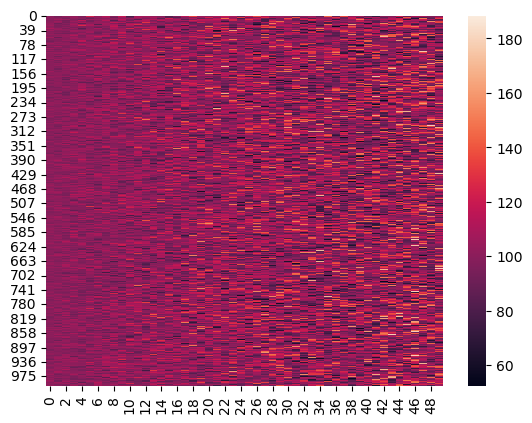

In [10]:
sb.heatmap(mesh1)

<AxesSubplot:>

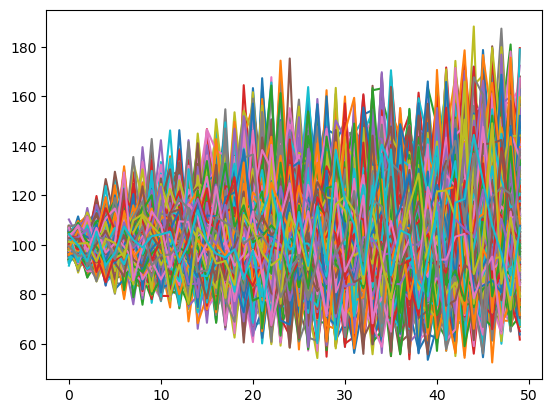

In [11]:
pd.DataFrame(mesh1).T.plot(legend = False)

<AxesSubplot:>

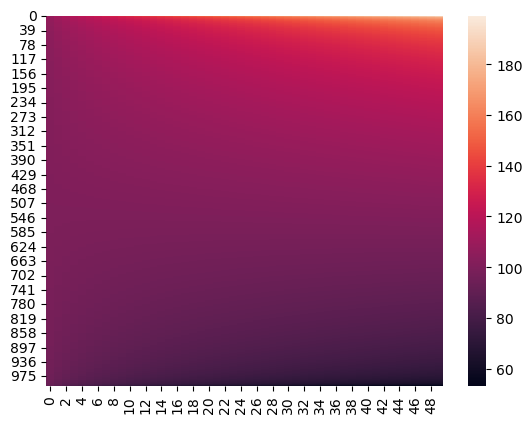

In [12]:
sb.heatmap(mesh2)

<AxesSubplot:>

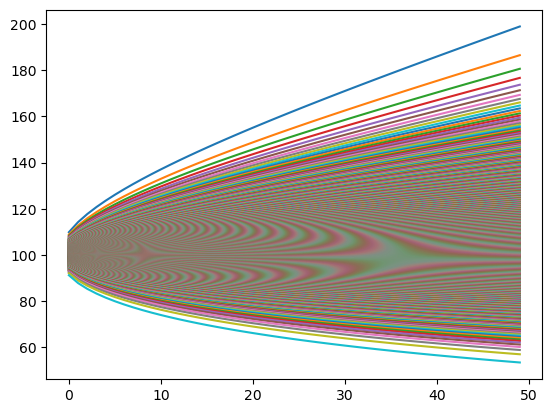

In [13]:
pd.DataFrame(mesh2).T.plot(legend = False)

<AxesSubplot:>

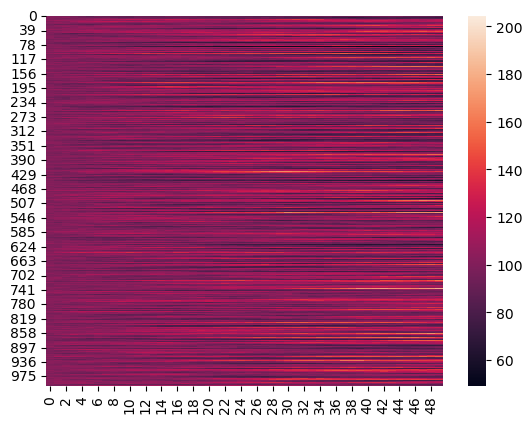

In [14]:
sb.heatmap(mesh3)

<AxesSubplot:>

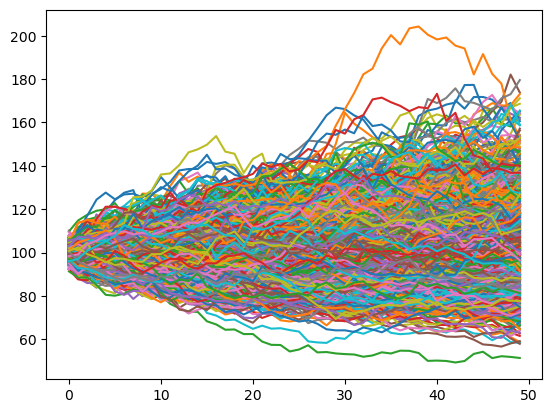

In [15]:
pd.DataFrame(mesh3).T.plot(legend = False)

# Wagi

In [16]:
def f(x_curr, x_next, dt, r, sigma):
    return 1/(x_next*sigma*np.sqrt(dt*2*np.pi))*np.exp(-(np.log(x_next/x_curr)-(r - 0.5*sigma**2)*dt)**2/(2*sigma**2*dt))

In [17]:
def weights1(t, x_curr_mesh, x_next_mesh, S0, dt, r, sigma): #article
    b = x_curr_mesh.shape[0]
    f_x_mesh = []
    for x_curr in x_curr_mesh:
        f_x_mesh.append(f(x_curr, x_next_mesh, dt, r, sigma))
    g_x_mesh = 1/b * sum(f_x_mesh)
    f_x_mesh = np.array(f_x_mesh)
    return f_x_mesh / g_x_mesh

In [18]:
def weights2(t, x_curr_mesh, x_next_mesh, S0, dt, r, sigma): #simulations
    w = []
    g = f(S0, x_next_mesh, t, r, sigma)
    for x_curr in x_curr_mesh:
        w.append(f(x_curr, x_next_mesh, dt, r, sigma) / g)
    return np.array(w)

In [19]:
w11 = weights1(T - dt, mesh1[:,-2],mesh1[:,-1], S0, dt,r,sigma)
w12 = weights2(T - dt, mesh1[:,-2],mesh1[:,-1], S0, dt,r,sigma)

w21 = weights1(T - dt, mesh2[:,-2],mesh2[:,-1],S0, dt,r,sigma)
w22 = weights2(T - dt, mesh2[:,-2],mesh2[:,-1],S0, dt,r,sigma)

w31 = weights1(T - dt, mesh3[:,-2],mesh3[:,-1],S0, dt,r,sigma)
w32 = weights2(T - dt, mesh3[:,-2],mesh3[:,-1],S0, dt,r,sigma)

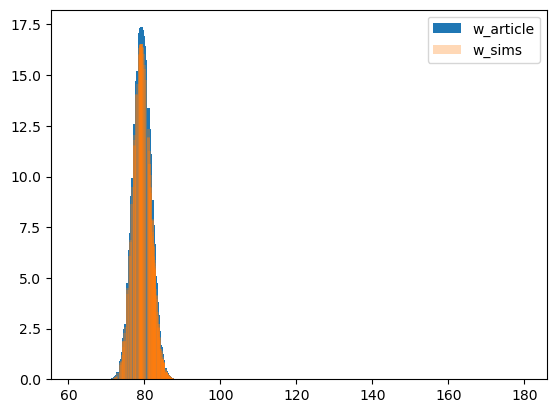

In [20]:
plt.bar(mesh1[:,-1],w11[-1,:], alpha = 1, label = 'w_article')
plt.bar(mesh1[:,-1],w12[-1,:], alpha = 0.3, label = 'w_sims')
plt.legend(loc = 'upper right')

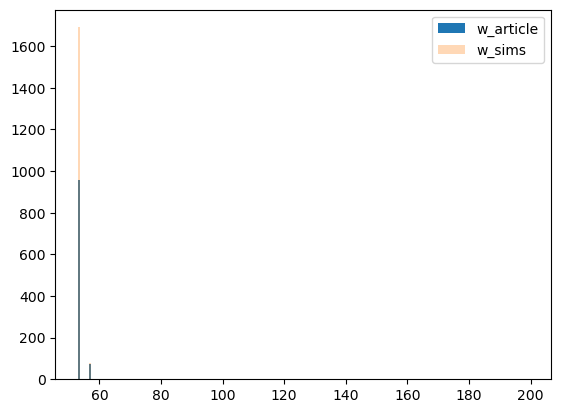

In [21]:
plt.bar(mesh2[:,-1],w21[-1,:], alpha = 1, label = 'w_article')
plt.bar(mesh2[:,-1],w22[-1,:], alpha = 0.3, label = 'w_sims')
plt.legend(loc = 'upper right')

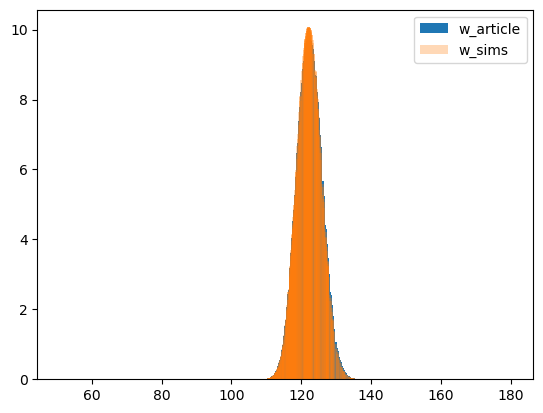

In [22]:
plt.bar(mesh3[:,-1],w31[b//2,:], alpha = 1, label = 'w_article')
plt.bar(mesh3[:,-1],w32[b//2,:], alpha = 0.3, label = 'w_sims')
plt.legend(loc = 'upper right')

# Testy

In [23]:
def stochastic_mesh(mesh_f, w_f, payoff_f, b, exercises_per_year, T, dt, S0, r, sigma):
    mesh = mesh_f(b, exercises_per_year, T, dt, S0, r, sigma)
    Q = payoff_f(mesh)
    bools = np.ones(Q.shape)
    for i in range(1,Q.shape[1]):
        w = w_f(T - i*dt, mesh[:,-(i+1)], mesh[:,-i], S0, dt, r, sigma)
        Q_new = (w * Q[:,-i]).mean(axis = 1)
        bools[:,-(i+1)] = Q[:,-(i+1)] > (Q_new * np.exp(-r * dt))
        Q[:,-(i+1)] = np.maximum(Q[:,-(i+1)] , Q_new * np.exp(-r * dt))
    V = np.maximum(payoff_f(S0), Q[:,0].mean() * np.exp(-r * dt))
    return (V, bools, mesh, Q)

In [24]:
price, bools, mesh, Q = stochastic_mesh(mesh_generator1, weights1, lambda x: payoff_call(x, K), b, exercises_per_year, T, dt, S0, r, sigma)

Text(0.5, 1.0, 'V0 = 11.508630711808497')

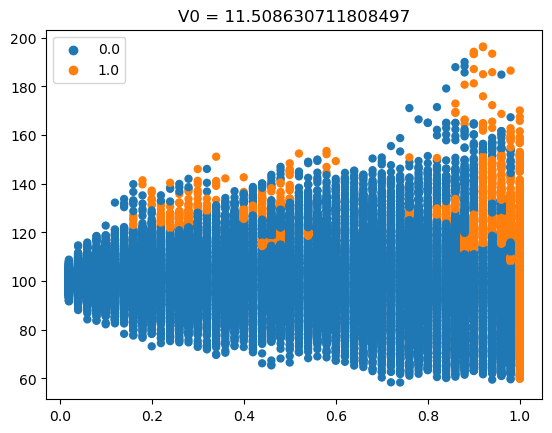

In [25]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(), linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 11.508630711808497')

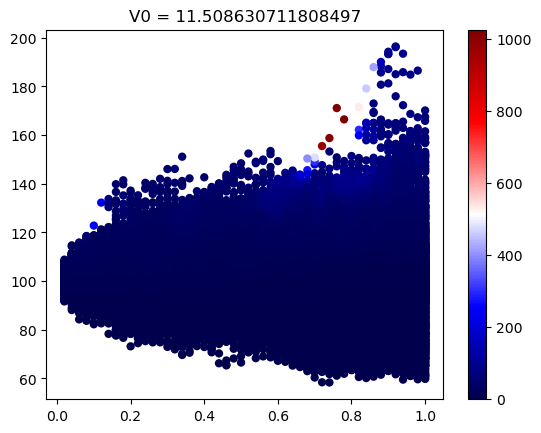

In [26]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [27]:
price, bools, mesh, Q = stochastic_mesh(mesh_generator3,weights1,lambda x: payoff_call(x, K), b, exercises_per_year, T, dt, S0, r, sigma)

Text(0.5, 1.0, 'V0 = 12.383786490416114')

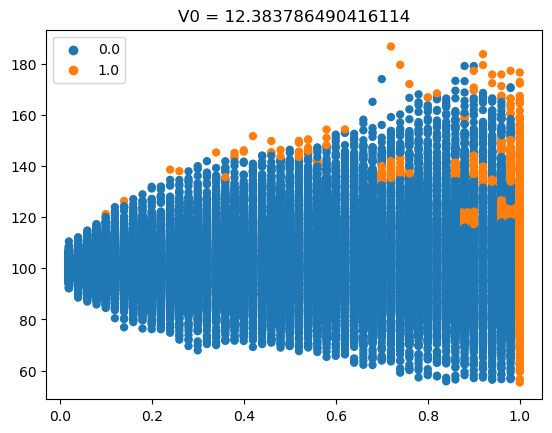

In [28]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 14.265220553112801')

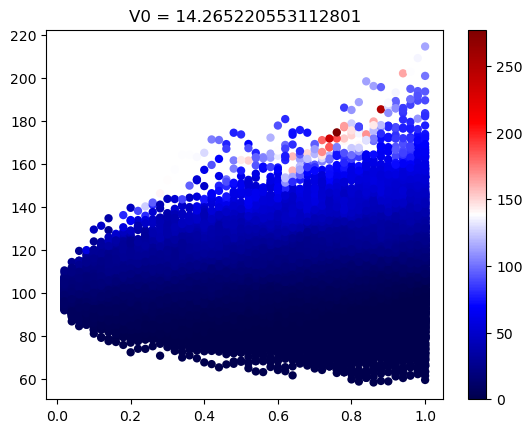

In [29]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [30]:
price, bools, mesh, Q = stochastic_mesh(mesh_generator2,weights1,lambda x: payoff_call(x, K), b, exercises_per_year, T, dt, S0, r, sigma)

Text(0.5, 1.0, 'V0 = 13.298039923202904')

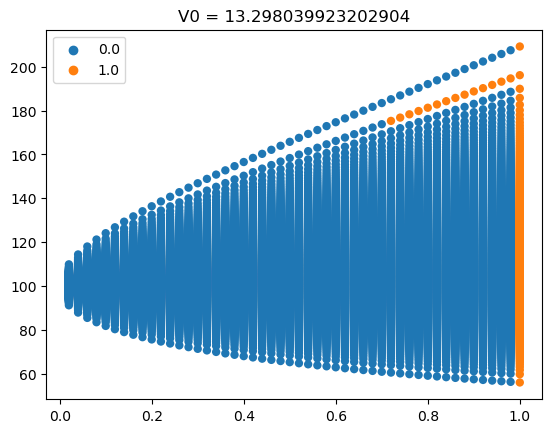

In [31]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 13.298039923202904')

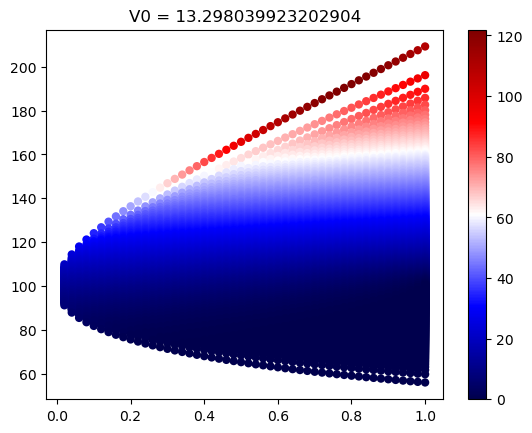

In [32]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [33]:
price, bools, mesh, Q = stochastic_mesh(mesh_generator1,weights2,lambda x: payoff_call(x, K), b, exercises_per_year, T, dt, S0, r, sigma)

Text(0.5, 1.0, 'V0 = 3921240133.9769244')

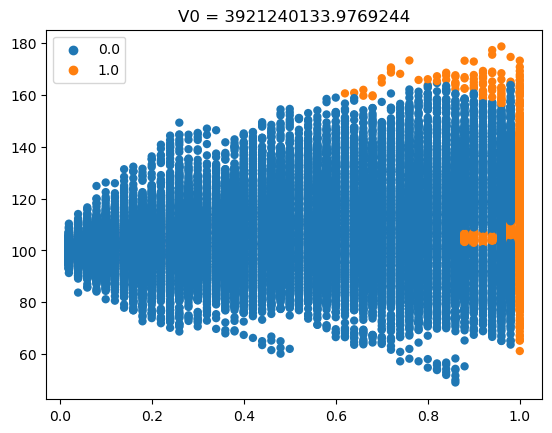

In [34]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 3921240133.9769244')

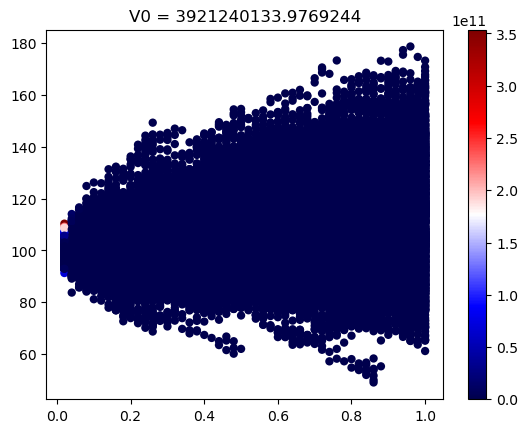

In [35]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [36]:
price, bools, mesh, Q = stochastic_mesh(mesh_generator3,weights2,lambda x: payoff_call(x, K), b, exercises_per_year, T, dt, S0, r, sigma)

Text(0.5, 1.0, 'V0 = 17407202.181586858')

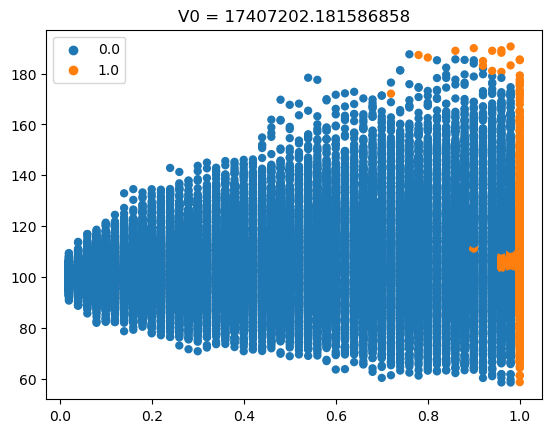

In [37]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 17407202.181586858')

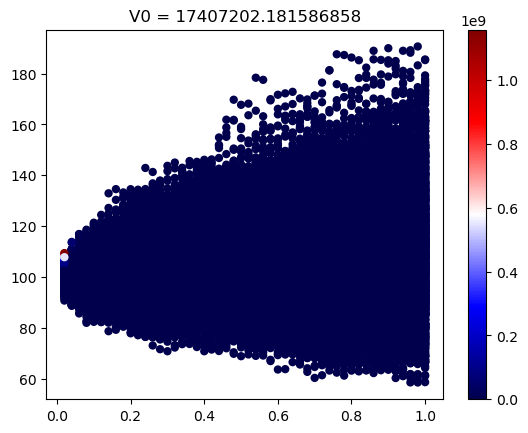

In [38]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [39]:
price, bools, mesh, Q = stochastic_mesh(mesh_generator2,weights2,lambda x: payoff_call(x, K), b, exercises_per_year, T, dt, S0, r, sigma)

Text(0.5, 1.0, 'V0 = 109119795631.3736')

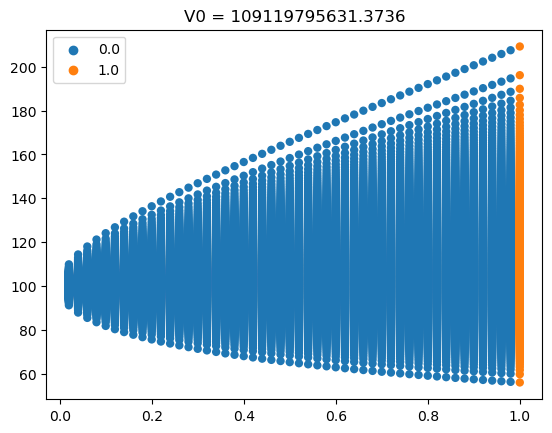

In [40]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 109119795631.3736')

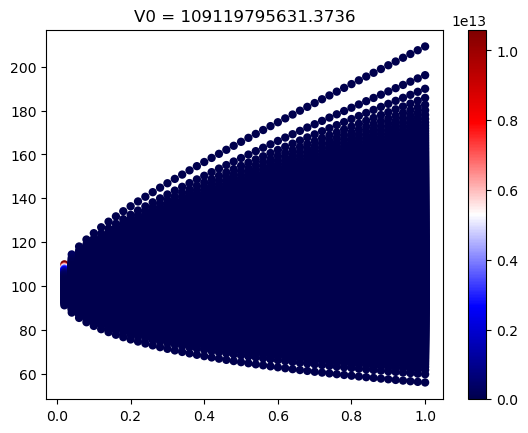

In [41]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [42]:
price, bools, mesh, Q = stochastic_mesh(mesh_generator1, weights1, lambda x: payoff_put(x, K), b, exercises_per_year, T, dt, S0, r, sigma)

Text(0.5, 1.0, 'V0 = 6.690424835254592')

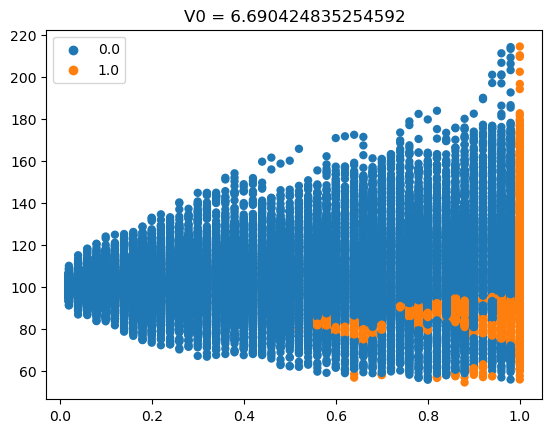

In [43]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 6.690424835254592')

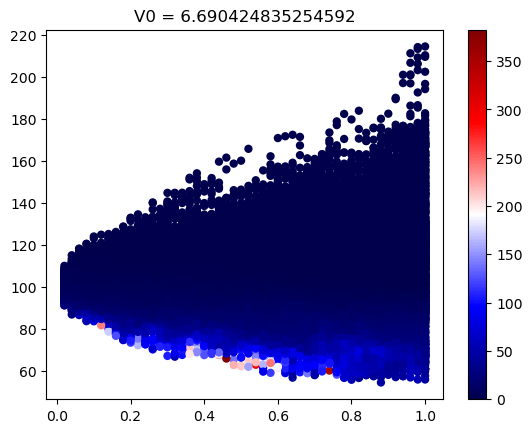

In [44]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [45]:
price, bools, mesh, Q = stochastic_mesh(mesh_generator3,weights1,lambda x: payoff_put(x, K), b, exercises_per_year, T, dt, S0, r, sigma)

Text(0.5, 1.0, 'V0 = 4.915807584372002')

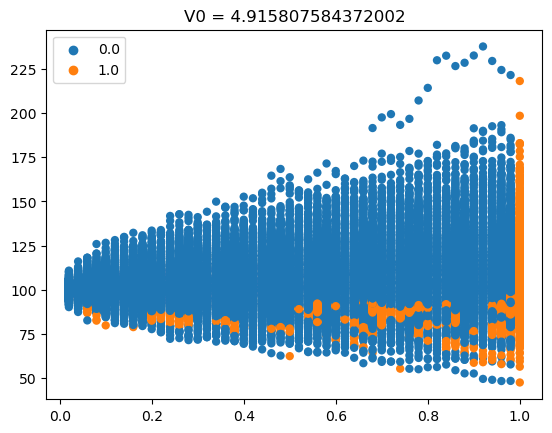

In [46]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 4.915807584372002')

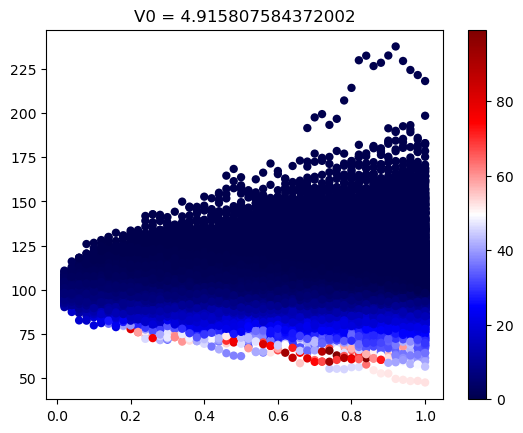

In [47]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [48]:
price, bools, mesh, Q = stochastic_mesh(mesh_generator2,weights1,lambda x: payoff_put(x, K), b, exercises_per_year, T, dt, S0, r, sigma)

Text(0.5, 1.0, 'V0 = 4.794770211398283')

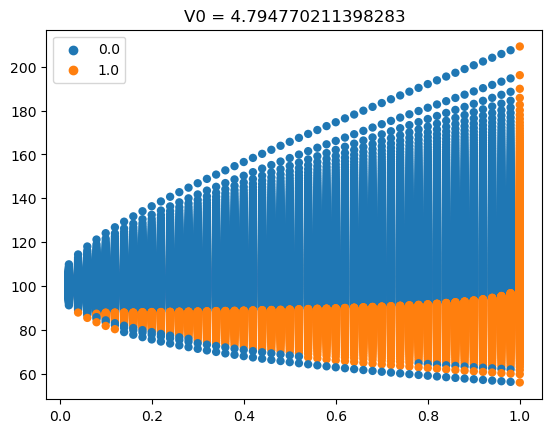

In [49]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 4.794770211398283')

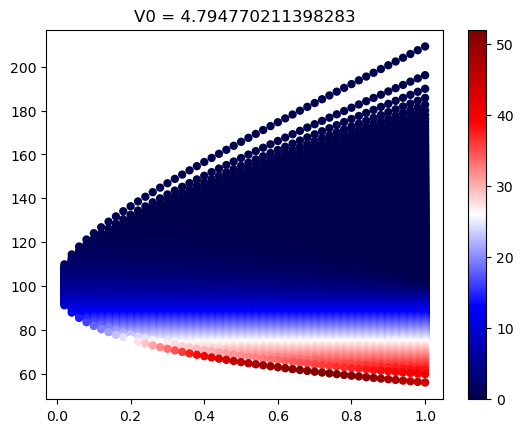

In [50]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [51]:
price, bools, mesh, Q = stochastic_mesh(mesh_generator1,weights2,lambda x: payoff_put(x, K), b, exercises_per_year, T, dt, S0, r, sigma)

Text(0.5, 1.0, 'V0 = 28658.15449673402')

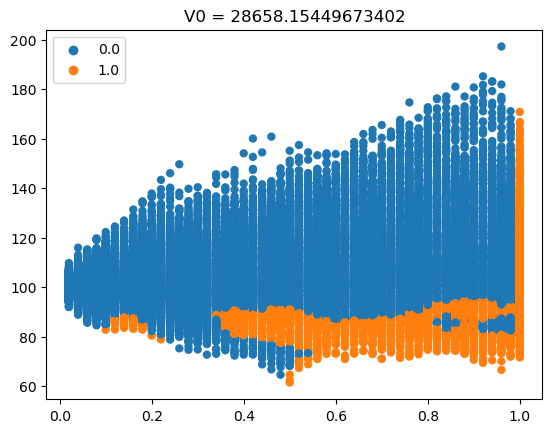

In [52]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 28658.15449673402')

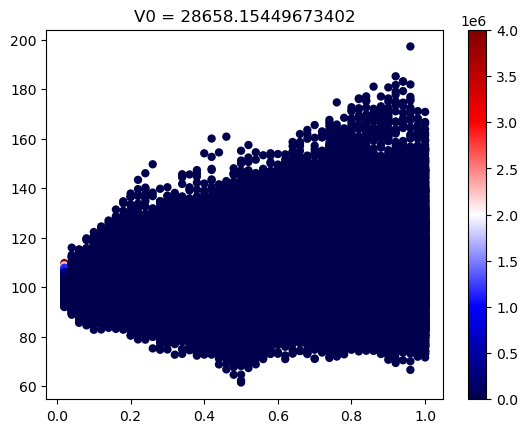

In [53]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [54]:
price, bools, mesh, Q = stochastic_mesh(mesh_generator3,weights2,lambda x: payoff_put(x, K), b, exercises_per_year, T, dt, S0, r, sigma)

Text(0.5, 1.0, 'V0 = 8652472.307631932')

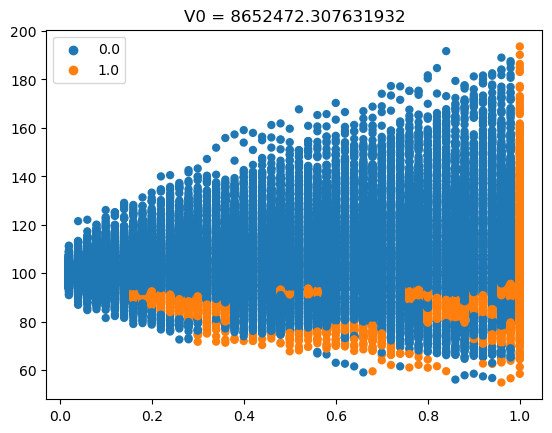

In [55]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 8652472.307631932')

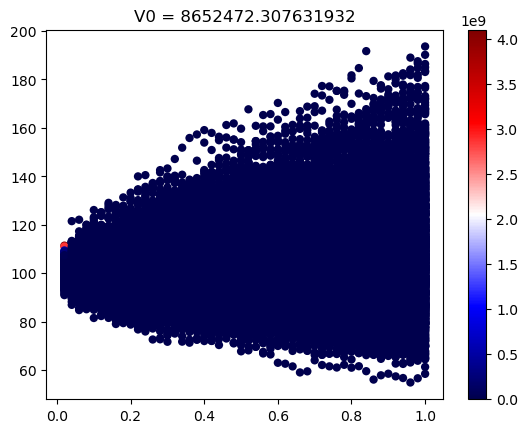

In [56]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [57]:
price, bools, mesh, Q = stochastic_mesh(mesh_generator2,weights2,lambda x: payoff_put(x, K), b, exercises_per_year, T, dt, S0, r, sigma)

Text(0.5, 1.0, 'V0 = 335159210.4792001')

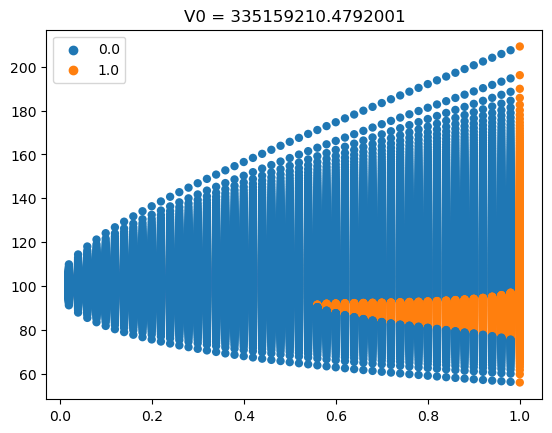

In [58]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 335159210.4792001')

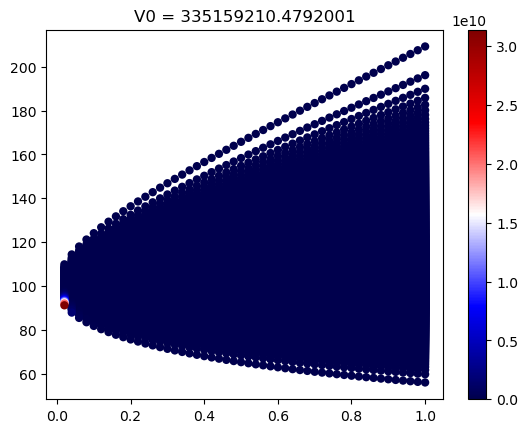

In [59]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [1158]:
bs = range(1,12)
exercises = range(2, 10, 2)
Vs = pd.DataFrame(index = bs, columns = [f'exercises per year = 2^{e}' for e in exercises])
for b in bs:
    for e in exercises:
        dt = 1 / (2**e)
        price, _, _, _ = stochastic_mesh(mesh_generator1,weights1,lambda x: payoff_call(x, K), 2**b, 2**e, T, dt, S0, r, sigma)
        Vs.loc[b, f'exercises per year = 2^{e}'] = price

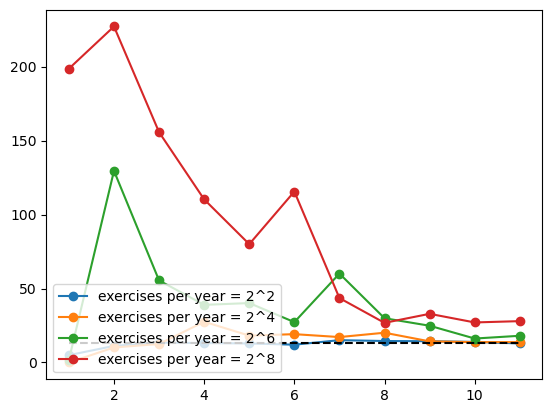

In [1159]:
Vs.plot(style = '-o')
plt.legend(loc = 'lower left')
plt.hlines(xmin = 1, xmax = len(bs), y = 13.269677, linestyles = 'dashed', color = 'black')

In [1160]:
bs = range(1,12)
exercises = range(2, 10, 2)
Vs = pd.DataFrame(index = bs, columns = [f'exercises per year = 2^{e}' for e in exercises])
for b in bs:
    for e in exercises:
        dt = 1 / (2**e)
        price, _, _, _ = stochastic_mesh(mesh_generator3,weights1,lambda x: payoff_call(x, K), 2**b, 2**e, T, dt, S0, r, sigma)
        Vs.loc[b, f'exercises per year = 2^{e}'] = price

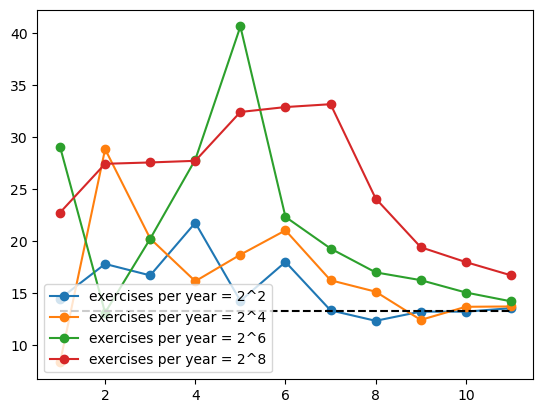

In [1161]:
Vs.plot(style = '-o')
plt.legend(loc = 'lower left')
plt.hlines(xmin = 1, xmax = len(bs), y = 13.269677, linestyles = 'dashed', color = 'black')

In [1154]:
bs = range(1,12)
exercises = range(2, 10, 2)
Vs = pd.DataFrame(index = bs, columns = [f'exercises per year = 2^{e}' for e in exercises])
for b in bs:
    for e in exercises:
        dt = 1 / (2**e)
        price, _, _, _ = stochastic_mesh(mesh_generator2,weights1,lambda x: payoff_call(x, K), 2**b, 2**e, T, dt, S0, r, sigma)
        Vs.loc[b, f'exercises per year = 2^{e}'] = price

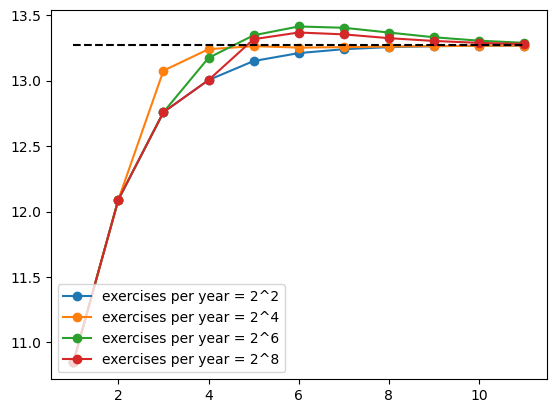

In [1155]:
Vs.plot(style = '-o')
plt.legend(loc = 'lower left')
plt.hlines(xmin = 1, xmax = len(bs), y = 13.269677, linestyles = 'dashed', color = 'black')

In [1166]:
bs = range(1,12)
exercises = range(2, 10, 2)
Vs = pd.DataFrame(index = bs, columns = [f'exercises per year = 2^{e}' for e in exercises])
for b in bs:
    for e in exercises:
        dt = 1 / (2**e)
        price, _, _, _ = stochastic_mesh(mesh_generator1,weights1,lambda x: payoff_put(x, K), 2**b, 2**e, T, dt, S0, r, sigma)
        Vs.loc[b, f'exercises per year = 2^{e}'] = price

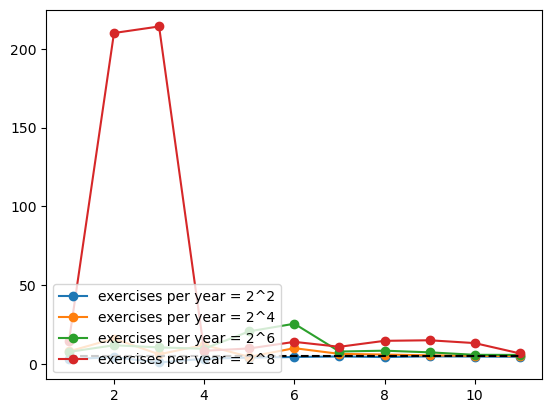

In [1167]:
Vs.plot(style = '-o')
plt.legend(loc = 'lower left')
plt.hlines(xmin = 1, xmax = len(bs), y = 4.830794, linestyles = 'dashed', color = 'black')

In [1168]:
bs = range(1,12)
exercises = range(2, 10, 2)
Vs = pd.DataFrame(index = bs, columns = [f'exercises per year = 2^{e}' for e in exercises])
for b in bs:
    for e in exercises:
        dt = 1 / (2**e)
        price, _, _, _ = stochastic_mesh(mesh_generator3,weights1,lambda x: payoff_put(x, K), 2**b, 2**e, T, dt, S0, r, sigma)
        Vs.loc[b, f'exercises per year = 2^{e}'] = price

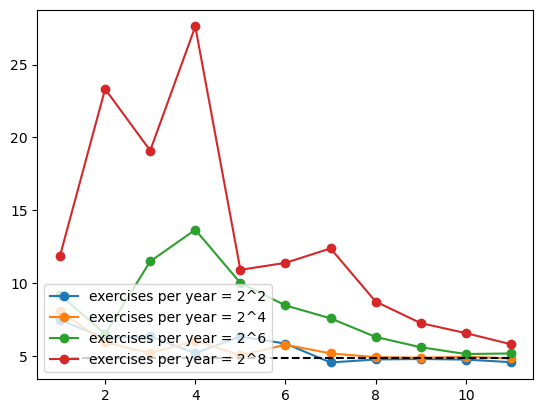

In [1169]:
Vs.plot(style = '-o')
plt.legend(loc = 'lower left')
plt.hlines(xmin = 1, xmax = len(bs), y = 4.830794, linestyles = 'dashed', color = 'black')

In [1156]:
bs = range(1,12)
exercises = range(2, 12, 2)
Vs = pd.DataFrame(index = bs, columns = [f'exercises per year = 2^{e}' for e in exercises])
for b in bs:
    for e in exercises:
        dt = 1 / (2**e)
        price, _, _, _ = stochastic_mesh(mesh_generator2,weights1,lambda x: payoff_put(x, K), 2**b, 2**e, T, dt, S0, r, sigma)
        Vs.loc[b, f'exercises per year = 2^{e}'] = price

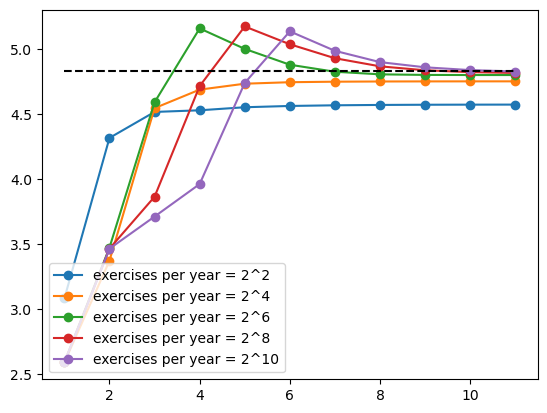

In [1157]:
Vs.plot(style = '-o')
plt.legend(loc = 'lower left')
plt.hlines(xmin = 1, xmax = len(bs), y = 4.830794, linestyles = 'dashed', color = 'black')

In [60]:
def stochastic_mesh_barrier(mesh_f, w_f, payoff_f, b, exercises_per_year, T, dt, S0, r, sigma, barrier, from_below):
    mesh = mesh_f(b, exercises_per_year, T, dt, S0, r, sigma)
    Q = payoff_f(mesh) * (mesh < barrier if from_below else mesh > barrier)
    bools = np.ones(Q.shape)
    bools[:,-1] = -1 + 2 * (mesh[:,-1] < barrier if from_below else mesh[:,-1] > barrier)
    for i in range(1,Q.shape[1]):
        w = w_f(T - i*dt, mesh[:,-(i+1)], mesh[:,-i], S0, dt, r, sigma)
        Q_new = (w * Q[:,-i]).mean(axis = 1)
        condition = (mesh[:,-(i+1)] < barrier if from_below else mesh[:,-(i+1)] > barrier)
        bools[:,-(i+1)] = (Q[:,-(i+1)] > (Q_new * np.exp(-r * dt))) * condition + (-1 + condition)
        Q[:,-(i+1)] = np.maximum(Q[:,-(i+1)] , (mesh[:,-(i+1)] < barrier if from_below else mesh[:,-(i+1)] > barrier) * Q_new * np.exp(-r * dt))
    V = np.maximum(payoff_f(S0), Q[:,0].mean() * np.exp(-r * dt))
    return (V, bools, mesh, Q)

In [61]:
T = 1
exercises_per_year = 100
dt = 1 / exercises_per_year
b = 1000

In [62]:
price, bools, mesh, Q = stochastic_mesh_barrier(mesh_generator3,weights1,lambda x: payoff_call(x, K), b, exercises_per_year, T, dt, S0, r, sigma, 150, True)

Text(0.5, 1.0, 'V0 = 14.23628317622398')

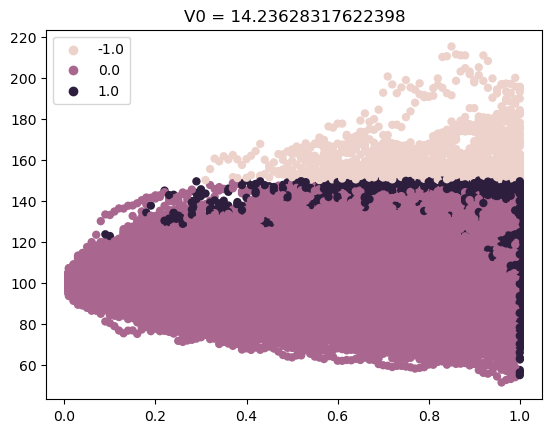

In [63]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 14.23628317622398')

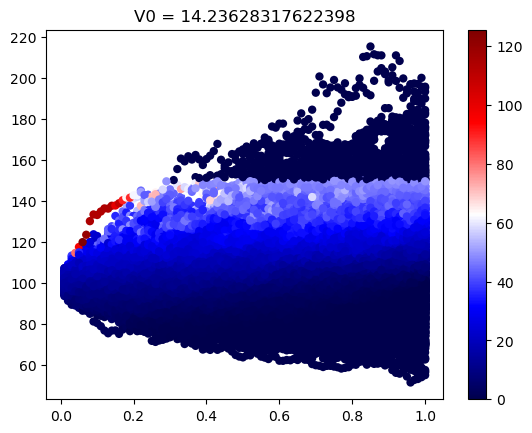

In [64]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [141]:
price, bools, mesh, Q = stochastic_mesh_barrier(mesh_generator2,weights1,lambda x: payoff_put(x, K), b, exercises_per_year, T, dt, S0, r, sigma, 80, False)

Text(0.5, 1.0, 'V0 = 4.805380161518399')

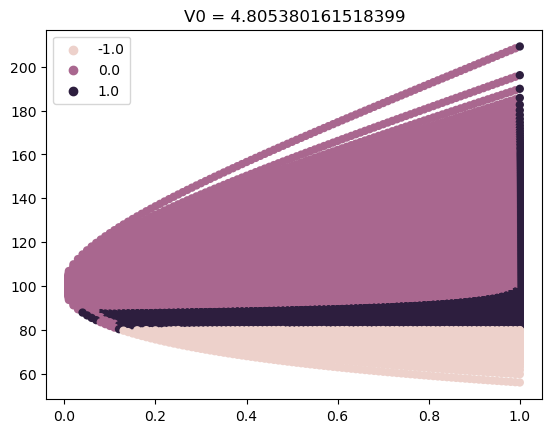

In [142]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 4.805380161518399')

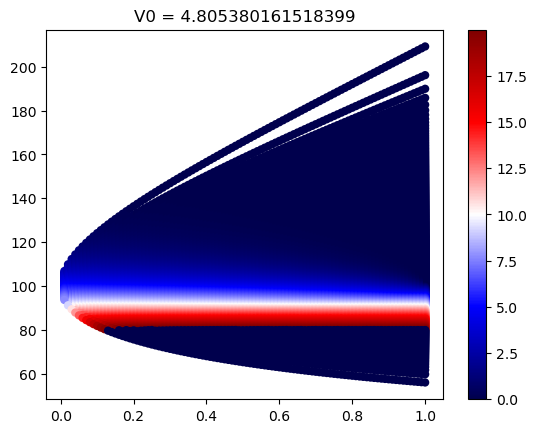

In [143]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')

In [105]:
def stochastic_mesh2d(mesh_f, w_f, payoff_f, b, exercises_per_year, T, dt, S0s, r, sigmas):
    mesh1 = mesh_f(b, exercises_per_year, T, dt, S0s[0], r, sigmas[0])
    mesh2 = mesh_f(b, exercises_per_year, T, dt, S0s[1], r, sigmas[1])
    Q = payoff_f(mesh1, mesh2)
    bools = np.ones(Q.shape)
    for i in range(1,Q.shape[1]):
        w = w_f(T - i*dt, mesh2[:,-(i+1)], mesh2[:,-i], S0s[0], dt, r, sigmas[0])
        Q_new = (w * Q[:,-i]).mean(axis = 1)
        bools[:,-(i+1)] = Q[:,-(i+1)] > (Q_new * np.exp(-r * dt))
        Q[:,-(i+1)] = np.maximum(Q[:,-(i+1)] , Q_new * np.exp(-r * dt))
    V = np.maximum(payoff_f(S0s[0],S0s[1]), Q[:,0].mean() * np.exp(-r * dt))
    return (V, bools, mesh1, mesh2, Q)

In [106]:
price, bools, mesh1, mesh2, Q = stochastic_mesh2d(mesh_generator3,weights1,lambda x,y: payoff_put(x, 120)*(y > 140), b, exercises_per_year, T, dt, [100, 100], r, [sigma,sigma])

Text(0.5, 1.0, 'V0 = 4.78779759958339')

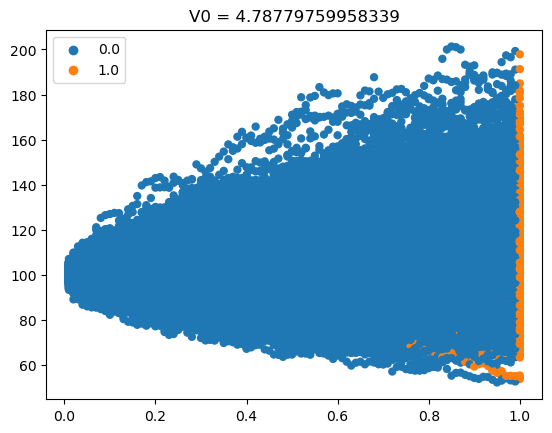

In [107]:
sb.scatterplot(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh1).flatten(), hue = bools.flatten(),linewidth=0).set_title(f'V0 = {price}')

Text(0.5, 1.0, 'V0 = 4.78779759958339')

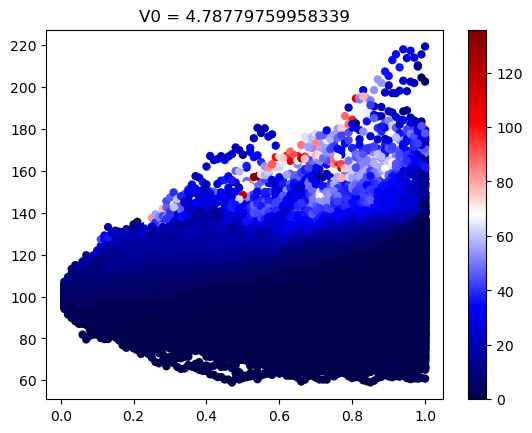

In [108]:
plt.scatter(x = (np.tile(np.arange(1,exercises_per_year * T + 1) * dt, (b,1))).flatten(),y = (mesh2).flatten(), c = Q.flatten(), cmap = 'seismic', linewidth=0)
plt.colorbar()
plt.title(f'V0 = {price}')